# Compare MB gradients 

#### plot the thickness difference for an individual glacier between OGGM linear gradient and a user defined mass balance gradient

In [130]:
##Ben Pelto June 2019

# Python imports
import os
import pandas as pd
import salem
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.workflow import execute_entity_task, gis_prepro_tasks, climate_tasks

## Select the glacier by setting num to:

- 0 for Kokanee
- 1 for Haig
- 2 for Conrad
- 3 for W. Washmawapta (no DEM correction available)
- 4 for Illecillewaet (not supported in this version of the script due to shapefile reasons)
- 5 for Nordic (not supported in this version of the script due to shapefile reasons)
- 6 for Zillmer
- 7 Castle Creek

In [131]:
num = 5 #num determines which gdir and gradient to use

#observational data points gradients
grad = [6.84, 9.8, 7.11, 9.8, 10.84, 6.01, 7.92, 7.19] # mm w.e. m-1 

fl_smooth = 1  # Gaussian smooth of the altitude along a flowline 
# sigma, in pixel coordinates (sigma=1 -> smooth around a -4:+4 window)

srtm = [-1.58, -6.95, -6.47, -5.71, -5.86, -6.11, 0.48, -6.00]
products_dir = '/home/pelto/Desktop/ice_thick/'
glacier = ['Kokanee', 'Haig', 'Conrad', 'W.Washmawapta', 'Illecillewaet', 'Nordic', 'Zillmer', 'Castle']

WORKING_DIR = utils.get_temp_dir('test_thickNEW' + glacier[num])
utils.mkdir(WORKING_DIR, reset=True)
cfg.initialize(logging_level='WORKFLOW')
cfg.PATHS['working_dir'] = WORKING_DIR

# dx = 100 
# cfg.PARAMS['use_rgi_area'] = False
cfg.PARAMS['border'] = 10
cfg.PARAMS['flowline_height_smooth'] = fl_smooth
# A = [7.65e-24, 2.99e-24,9.78e-24, 0.32e-24,5.37e-24,9.75e-24,8.7e-24]

# cfg.PARAMS['glen_a'] = A[num]
cfg.PARAMS['smooth_window'] = 251.

#testing effect of larger grid cell size
# cfg.PARAMS['grid_dx_method'] = 'fixed'
# cfg.PARAMS['fixed_dx'] = dx
if glacier[num] == 'W.Washmawapta' or 'Nordic':
    cfg.PARAMS['use_intersects'] = False
    
    # Get the RGI IDs for the run.
rgi_list = ['RGI60-02.00147', 'RGI60-02.01857', 'RGI60-02.02171', 'RGI60-02.03411', 'RGI60-02.03688',
            'RGI60-02.04264', 'RGI60-02.07780', 'RGI60-02.08783']

2020-05-05 15:43:45: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_pub/lib/python3.7/site-packages/oggm/params.cfg
2020-05-05 15:43:45: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-05-05 15:43:45: oggm.cfg: Multiprocessing: using all available processors (N=8)
2020-05-05 15:43:45: oggm.cfg: PARAMS['border'] changed from `20` to `10`.
2020-05-05 15:43:45: oggm.cfg: PARAMS['use_intersects'] changed from `True` to `False`.


In [132]:
rgidf = utils.get_rgi_glacier_entities([rgi_list[num]]) # Get a list of glacier outlines selected by RGI IDs
gdirs = workflow.init_glacier_directories(rgidf) # Initializes the list of Glacier Directories for this run
workflow.execute_entity_task(tasks.define_glacier_region, gdirs) 
workflow.gis_prepro_tasks(gdirs)        # runs all flowline preprocessing tasks
workflow.climate_tasks(gdirs)           # runs all climate related tasks
workflow.inversion_tasks(gdirs)         #runs all ice thickness inversion tasks
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);
gdir = gdirs[0]
tasks.init_present_time_glacier(gdir) ##This updates the mode_flowlines file and creates a stand-alone numerical glacier ready to run.

2020-05-05 15:43:46: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2020-05-05 15:43:46: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2020-05-05 15:43:47: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2020-05-05 15:43:47: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2020-05-05 15:43:47: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2020-05-05 15:43:47: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2020-05-05 15:43:47: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2020-05-05 15:43:47: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2020-05-05 15:43:47: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
2020-05-05 15:43:48: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2020-05-05 15:43:48: oggm.workflow: Execute entity task catchment_width_correction on 1 g

In [133]:
# ds_default is the default inversion gridded data
ds_default = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
ds_default.close()
gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-02.04264
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 4.425 km2
  Lon, Lat: (-117.71, 51.4292)
  Grid (nx, ny): (116, 73)
  Grid (dx, dy): (39.0, -39.0)

slope: 5.446078    intercept: -13773.362184   R-squared: 0.940217


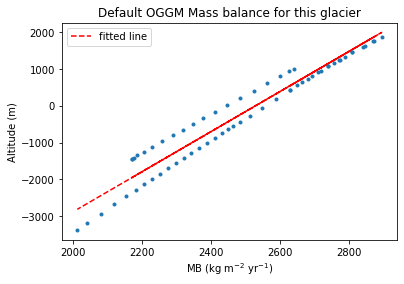

In [134]:
from oggm.core.massbalance import ConstantMassBalance, MultipleFlowlineMassBalance
# gdir = gdirs[num]

mb_mod = MultipleFlowlineMassBalance(gdir, use_inversion_flowlines=True, mb_model_class=ConstantMassBalance)
z, w, mb_on_z = mb_mod.get_annual_mb_on_flowlines()
mb_on_z *=  cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

# grad_line = np.polyfit(mb_on_z,z,2)
from scipy import stats 
slope, intercept, r_value, p_value, std_err = stats.linregress(z, mb_on_z)

# Print the standard MB gradient from OGGM default
print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)

#plot the OGGM default gradient for this glacier
plt.plot(z, intercept + slope*z, 'r--', label='fitted line');
plt.plot(z, mb_on_z, '.');
plt.title('Default OGGM Mass balance for this glacier');
plt.xlabel('MB (kg m$^{-2}$ yr$^{-1}$)');
plt.ylabel('Altitude (m)');
plt.legend();

In [135]:
#calculate thickness along the model flowline
mfl=gdir.read_pickle('model_flowlines')
thickness_default = mfl[-1].surface_h - mfl[-1].bed_h
# thickness_default.mean()
default_thick = thickness_default[thickness_default>0].mean() #remove zeros from thickness calculation
print('default flowline thickness:', np.round(default_thick,2))

default flowline thickness: 57.58


In [136]:
# Let's apply a linear MB instead
from oggm.core.climate import apparent_mb_from_linear_mb
workflow.execute_entity_task(tasks.apparent_mb_from_linear_mb, gdir, mb_gradient=grad[num]);

2020-05-05 15:43:49: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers


In [137]:
# Compare what we got from this
from oggm.core.massbalance import LinearMassBalance

params = gdir.read_pickle('linear_mb_params')
print(params)

#max_mb Cap the mass balance to a certain value (unit: [mm w.e. yr-1], we use 2000 mm w.e.
l_mb_mod = LinearMassBalance(params['ela_h'], grad=params['grad'], max_mb=2000.)
l_mb_on_z = l_mb_mod.get_annual_mb(z) * cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

{'ela_h': 2488.8671451650553, 'grad': 6.01}


slope default: 5.446078    intercept: -13773.362184   R-squared: 0.940217
slope: 5.868930    intercept: -14629.566596   R-squared: 0.997520


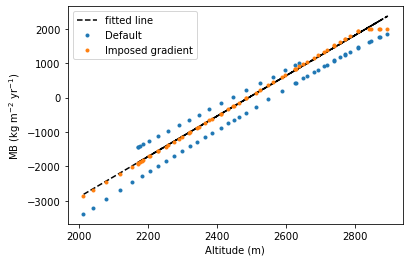

In [138]:
slope, intercept, r_value, p_value, std_err = stats.linregress(z, mb_on_z)
print("slope default: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)
slope, intercept, r_value, p_value, std_err = stats.linregress(z, l_mb_on_z)
print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)

plt.plot(z, intercept + slope*z, 'k--', label='fitted line');
plt.plot(z, mb_on_z, '.', label='Default');
plt.plot(z, l_mb_on_z, '.', label='Imposed gradient');
plt.ylabel('MB (kg m$^{-2}$ yr$^{-1}$)');
plt.xlabel('Altitude (m)');
plt.legend();

In [139]:
# Now let's recompute the inversion based on this new gradient
cfg.PARAMS['flowline_height_smooth'] = fl_smooth
workflow.inversion_tasks(gdirs)
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);
tasks.init_present_time_glacier(gdir) ##trying to update the model flowline

2020-05-05 15:43:50: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2020-05-05 15:43:50: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2020-05-05 15:43:50: oggm.workflow: Execute entity task filter_inversion_output on 1 glaciers
2020-05-05 15:43:50: oggm.workflow: Execute entity task distribute_thickness_per_altitude on 1 glaciers


In [140]:
#ds_new uses the in situ SMB gradient
ds_new = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
ds_new.close() 

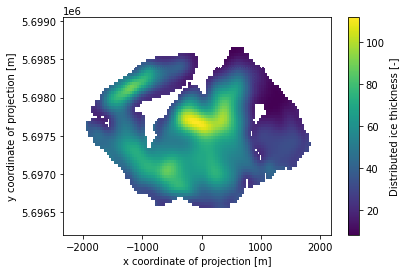

In [141]:
ds_new.distributed_thickness.plot();

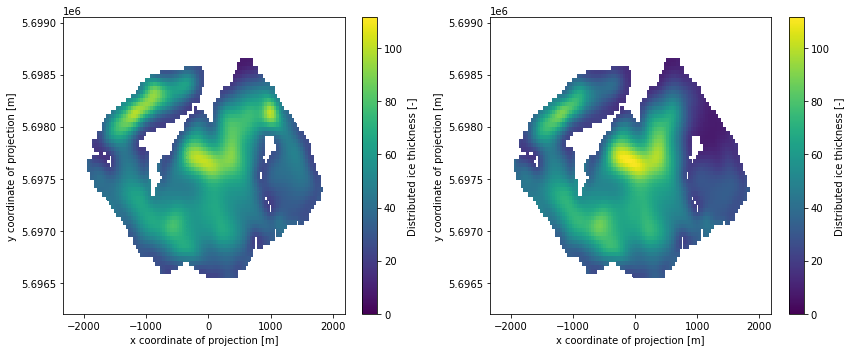

In [142]:
##side by side thickness...fine but hard to compare
vmax= ds_new.distributed_thickness.max()
vmin=0
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5));
ds_default.distributed_thickness.plot(ax=ax1, vmin=vmin, vmax=vmax); #default cmap is viridis
ds_new.distributed_thickness.plot(ax=ax2, vmin=vmin, vmax=vmax);
plt.tight_layout();

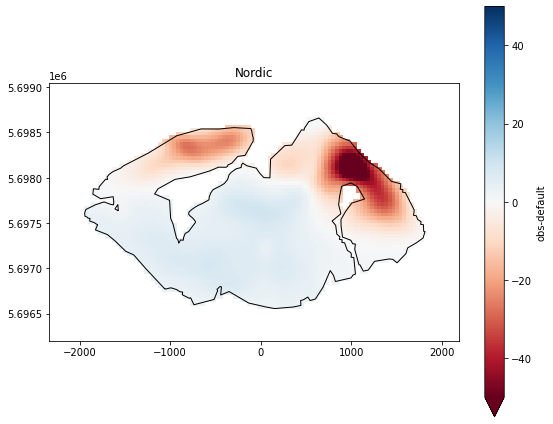

In [143]:
#plot thickness difference between the default SMB grad. inversion and in situ SMB grad. inversion
f, ax = plt.subplots(figsize=(8,6))
ds_new['obs-default'] = (ds_new.distributed_thickness - ds_default.distributed_thickness)
ds_new['obs-default'].plot(ax=ax, cmap='RdBu', vmin =-50, vmax=50); #'RdBu'
plt.ylabel('')
plt.xlabel('')
plt.title(glacier[num])
gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');
plt.tight_layout()
# plt.savefig('/home/pelto/Desktop/ice_thick/' + glacier[num] + '_mb_grad_diff.png', dpi=600)

In [144]:
# "whole glacier thickness"
print(np.mean(ds_new.distributed_thickness))
print(ds_default.distributed_thickness.mean())

<xarray.DataArray 'distributed_thickness' ()>
array(47.666336, dtype=float32)
<xarray.DataArray 'distributed_thickness' ()>
array(50.608433, dtype=float32)


### Flowline glacier thickness:

In [145]:
mfl=gdir.read_pickle('model_flowlines')
thickness_MB = mfl[-1].surface_h - mfl[-1].bed_h
# thickness_MB.mean()
MB_thick = thickness_MB[thickness_MB>0].mean() #remove zeros
print(np.round(MB_thick , 2))

59.02


In [146]:
#compare flowline thickness in situ -- default
diff =  MB_thick - default_thick
print(np.round(diff, 2))

1.45


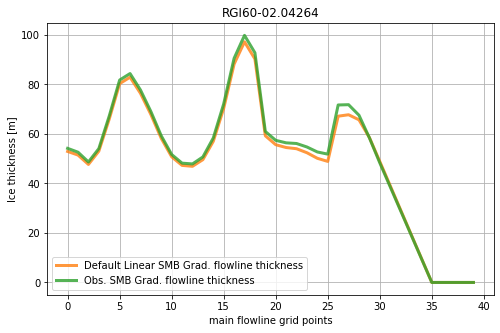

In [147]:
fig, ax = plt.subplots(figsize=[8,5])
ax.plot(thickness_default, 'C1', label='Default Linear SMB Grad. flowline thickness', linewidth=3, alpha=0.8)
ax.plot(thickness_MB, 'C2', label='Obs. SMB Grad. flowline thickness', linewidth=3, alpha=0.8)
ax.set_xlabel('main flowline grid points')
ax.set_ylabel('Ice thickness [m]')
ax.set_title(gdir.rgi_id)
ax.grid(True)
ax.legend();
fig.savefig(products_dir + glacier[num] +'.tiff')

In [148]:
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# graphics.plot_raster(gdir, var_name='aspect', cmap='twilight', ax=ax1)
# graphics.plot_raster(gdir, var_name='oggm_mb_above_z', ax=ax2)

# Import GPR observations

In [149]:
shapefile = ['2017/Kokanee_17_final_WGS84_clip.shp', 'Haig/Haig_gpr_all_WGS84.shp', 'conrad_GPR_ALL_final_WGS84.shp', 
             'west_wash_data.shp', '2018/illec_may18_final_WGS84_clipped.shp', '2016/Nordic_2016_GPR_final_WGS84.shp', 
             'zillmer_GPR_All_final_WGS84.shp']

##illecillewaet radar data causes failure if using RGI polygon due to data bounds, so I clipped the radar data for now

df = salem.read_shapefile('/home/pelto/GIS/GPR/Data/' + shapefile[num])

coords = np.array([p.xy for p in df.geometry]).squeeze()
df['lon'] = coords[:, 0]
df['lat'] = coords[:, 1]
# df['lon'] = df[4]
# df['lat'] = df[5]
df = df[['lon', 'lat', 'depth']]

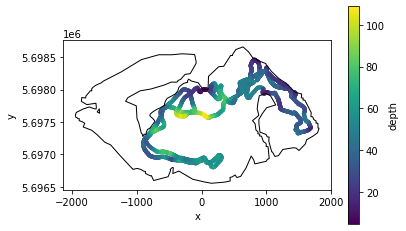

In [150]:
# Convert the longitudes and latitudes to the glacier map projection:
xx, yy = salem.transform_proj(salem.wgs84, gdir.grid.proj, df['lon'].values, df['lat'].values)
df['x'] = xx
df['y'] = yy

#plot these data
geom = gdir.read_shapefile('outlines')
f, ax = plt.subplots()
df.plot.scatter(x='x', y='y', c='depth',cmap='viridis', s=10, ax=ax); #cmap='Blues',
geom.plot(ax=ax, facecolor='none', edgecolor='k');

The measurement points of this dataset are very frequent and close to each other. There are plenty of them:

In [151]:
len(df)

3178

In [152]:
# Here, we will keep them all and interpolate the variables of interest at a the point's location. 
# We use xarray for this:
vns = ['topo',
       'slope',
       'slope_factor',
       'aspect',
       'dis_from_border',
#        'catchment_area',
#        'lin_mb_above_z',
#        'lin_mb_above_z_on_catch',
#        'oggm_mb_above_z',
#        'oggm_mb_above_z_on_catch',
       ]

In [153]:
# Interpolate (bilinear)
for vn in vns:
    df[vn] = ds_new[vn].interp(x=('z', df.x), y=('z', df.y))

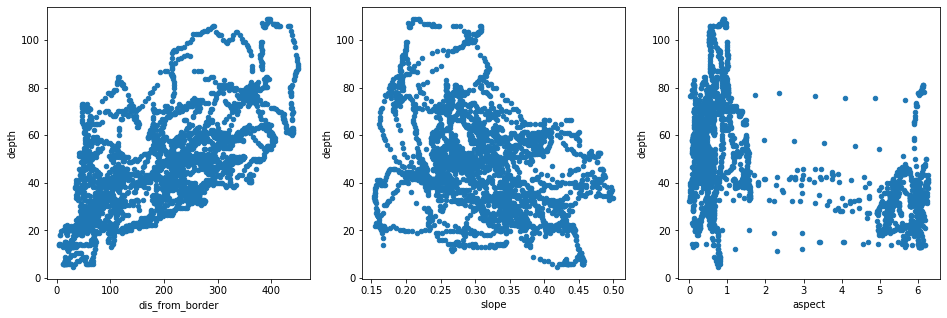

In [154]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
df.plot.scatter(x='dis_from_border', y='depth', ax=ax1);
df.plot.scatter(x='slope', y='depth', ax=ax2);
df.plot.scatter(x='aspect', y='depth', ax=ax3);

### Method 2: aggregated per grid point

There are so many points that much of the information obtained by OGGM is interpolated. A way to deal with this is to aggregate all the measurement points per grid point and average them. Let's do this: 

In [155]:
df_agg = df[['lon', 'lat', 'depth']].copy()
ii, jj = gdir.grid.transform(df['lon'], df['lat'], crs=salem.wgs84, nearest=True)
df_agg['i'] = ii
df_agg['j'] = jj
# We trick by creating an index of similar i's and j's
df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
df_agg = df_agg.groupby('ij').mean()


In [156]:
df_agg

,lon,lat,depth,i,j
ij,,,,,
0036_0047,-117.722902,51.425892,42.293333,36,47
0036_0048,-117.722938,51.425646,42.421429,36,48
0036_0049,-117.722871,51.425333,42.034286,36,49
0037_0045,-117.722357,51.426565,46.878000,37,45
0037_0046,-117.722556,51.426306,40.096154,37,46
...,...,...,...,...,...
0102_0040,-117.686080,51.428415,26.270000,102,40
0102_0041,-117.685910,51.428133,14.956667,102,41
0102_0042,-117.686098,51.427689,21.421111,102,42


In [157]:
# Select
for vn in vns:
    df_agg[vn] = ds_new[vn].isel(x=('z', df_agg.i), y=('z', df_agg.j))

In [158]:
import salem
from salem import *

In [159]:
ds_crs =check_crs(ds_new)
ds_crs

In [160]:
print(len(df_agg))
points_diff = (len(df) / len(df_agg))
print('We now have',  np.round(points_diff, 1), 'times less points, but the main features of the data remain unchanged:')

423
We now have 7.5 times less points, but the main features of the data remain unchanged:


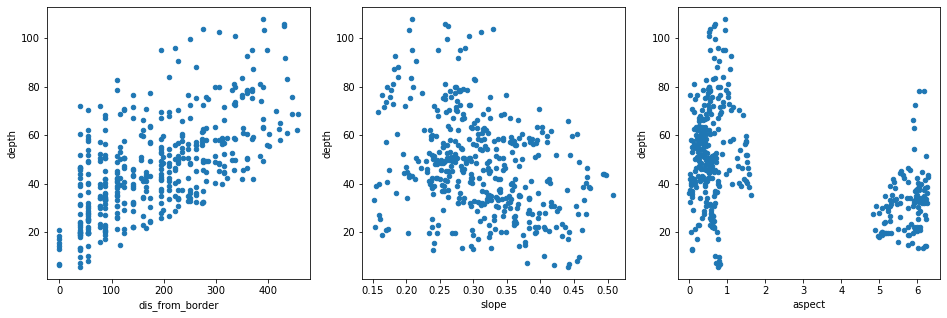

In [161]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
df_agg.plot.scatter(x='dis_from_border', y='depth', ax=ax1);
df_agg.plot.scatter(x='slope', y='depth', ax=ax2);
df_agg.plot.scatter(x='aspect', y='depth', ax=ax3);

In [162]:
# Add the linear model data for comparison
df_agg['oggm_thick'] = ds_default.distributed_thickness.isel(x=('z', df_agg['i']), y=('z', df_agg['j']))
df_agg['obs_mb_grad_thick'] = ds_new.distributed_thickness.isel(x=('z', df_agg['i']), y=('z', df_agg['j']))

In [163]:
print(len(df_agg['depth']), len(df_agg['oggm_thick']))
print('oggm_thick', np.round(np.mean(df_agg['oggm_thick']) + srtm[num],2), '+/-' , np.round(np.std(df_agg['oggm_thick'])))
print('obs_mb_grad_thick', np.round(np.mean(df_agg['obs_mb_grad_thick'])+ srtm[num],2), '+/-' , np.round(np.std(df_agg['obs_mb_grad_thick']),2))
thickness_GPR = df_agg['depth']
GPR_thick = thickness_GPR[thickness_GPR>0].mean()
print('GPR depth (m):', np.round(GPR_thick, 2), '+/-' ,  np.round(np.std(df_agg['depth']),2))

423 423
oggm_thick 53.94 +/- 18.0
obs_mb_grad_thick 45.48 +/- 27.66
GPR depth (m): 47.45 +/- 20.09


In [164]:
print('mean observed depth point:', np.round(df['depth'].mean(),2))
print('max observed depth gridded:', np.round(thickness_GPR.max(),2))
print('max observed depth point:', df['depth'].max())

mean observed depth point: 47.65
max observed depth gridded: 107.76
max observed depth point: 108.77


In [165]:
df_diff = df_agg['depth'] - (df_agg['oggm_thick']) #- 1.0)

print('mean diff:', np.mean(df_diff))
print('med. diff:', np.nanmedian(df_diff))

mean diff: -12.596455099141533
med. diff: -13.080184631347649


In [166]:
df_diff2 = df_agg['depth'] - (df_agg['obs_mb_grad_thick']) #- 1.0)

#df_diff
print('mean diff:', np.mean(df_diff2))
print('med. diff:', np.nanmedian(df_diff2))

mean diff: -4.138696245238202
med. diff: -2.1103419325086676


In [167]:
df_agg['perc_diff_GPR_obs_smb'] = (np.abs(df_agg['depth'] - df_agg['oggm_thick'])) / ((df_agg['depth'] + df_agg['oggm_thick'])/2.)
df_agg

,lon,lat,depth,i,j,topo,slope,slope_factor,aspect,dis_from_border,oggm_thick,obs_mb_grad_thick,perc_diff_GPR_obs_smb
ij,,,,,,,,,,,,,
0036_0047,-117.722902,51.425892,42.293333,36,47,2697.0,0.238986,2.360348,0.079670,117.000000,62.764969,69.523331,0.389720
0036_0048,-117.722938,51.425646,42.421429,36,48,2706.0,0.246399,2.317481,0.043920,156.000000,65.530739,72.624458,0.428140
0036_0049,-117.722871,51.425333,42.034286,36,49,2714.0,0.250729,2.293386,0.027916,195.000000,67.034897,74.335449,0.458436
0037_0045,-117.722357,51.426565,46.878000,37,45,2674.0,0.200229,2.624725,0.288439,39.000000,52.735813,58.362530,0.117610
0037_0046,-117.722556,51.426306,40.096154,37,46,2684.0,0.235958,2.378479,0.136987,78.000000,57.198402,63.336193,0.351556
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0102_0040,-117.686080,51.428415,26.270000,102,40,2444.0,0.360929,1.843093,5.540586,110.308655,34.110104,28.009249,0.259692
0102_0041,-117.685910,51.428133,14.956667,102,41,2457.0,0.377546,1.793981,5.752745,117.000000,34.145897,29.300467,0.781598
0102_0042,-117.686098,51.427689,21.421111,102,42,2473.0,0.407372,1.713979,5.931854,110.308655,32.817162,29.450485,0.420222


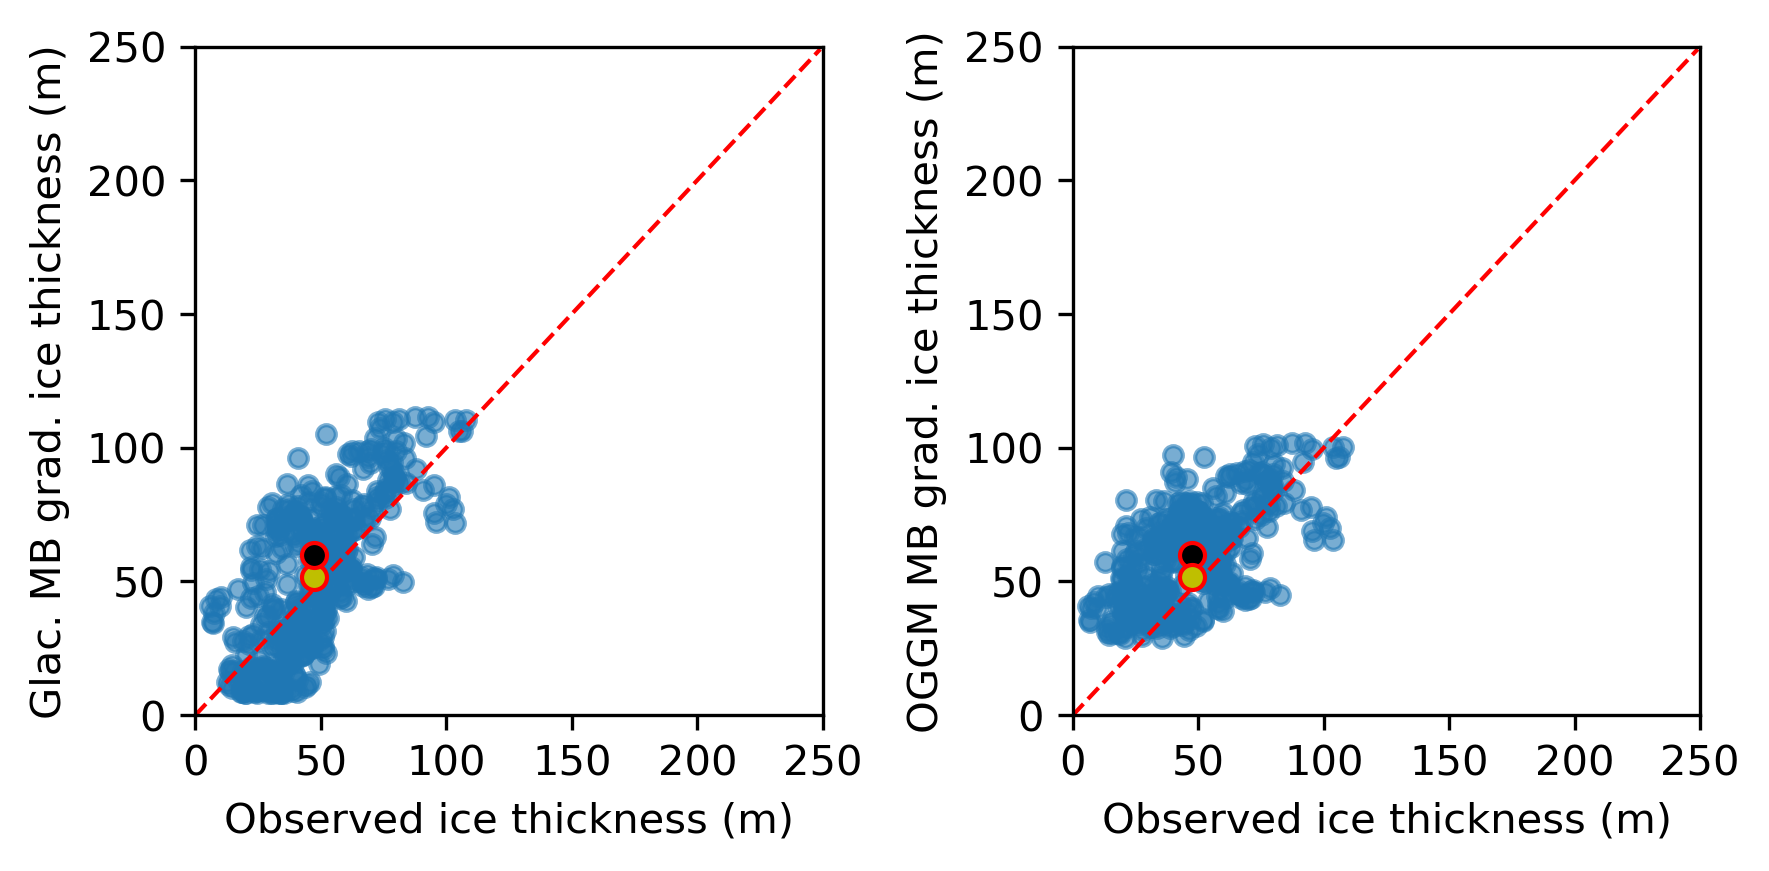

In [168]:
val = 250

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), dpi=300);

df_agg.plot.scatter(x='depth', y='obs_mb_grad_thick', ax=ax1, alpha=0.6);
ax1.plot(np.arange(0, val), np.arange(0, val), 'r--', linewidth=1, zorder=1)
ax1.plot(np.mean(df_agg['depth']), np.mean(df_agg['obs_mb_grad_thick']), 'yo', markeredgecolor='r')
ax1.plot(np.mean(df_agg['depth']), np.mean(df_agg['oggm_thick']), 'ko', markeredgecolor='r')#, alpha=.85)
ax1.set_xlabel('Observed ice thickness (m)')  #, fontsize=12)
ax1.set_ylabel('Glac. MB grad. ice thickness (m)') # , fontsize=12)
ax1.set_xlim([0, val]);
ax1.set_ylim([0, val]);

df_agg.plot.scatter(x='depth', y='oggm_thick', ax=ax2, alpha=0.6);
ax2.plot(np.arange(0, val), np.arange(0, val), 'r--', linewidth=1, zorder=1)
ax2.set_xlabel('Observed ice thickness (m)') #, fontsize=12)
ax2.plot(np.mean(df_agg['depth']), np.mean(df_agg['oggm_thick']), 'ko', markeredgecolor='r')#, alpha=.85)
ax2.plot(np.mean(df_agg['depth']), np.mean(df_agg['obs_mb_grad_thick']), 'yo', markeredgecolor='r')
ax2.set_xlim([0, val]);
ax2.set_ylim([0, val]);
ax2.set_ylabel('OGGM MB grad. ice thickness (m)') #, fontsize=12)

# plt.legend()
plt.tight_layout()
# plt.savefig(products_dir + glacier[num] + '_MB_grads_vs_gpr_ice_thick.png')

##need to correct for SRTM height change to asess performance

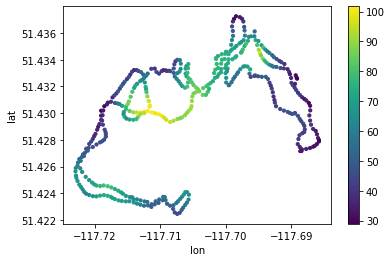

In [169]:
#plot these data
# geom = gdir.read_shapefile('outlines')
f, ax = plt.subplots()
# diff = df_agg['oggm_thick'] - df_agg['obs_mb_grad_thick']
df_agg.plot.scatter(x='lon', y='lat', c=df_agg['oggm_thick'], cmap='viridis', s=10, ax=ax); #cmap='Blues',
# geom.plot(ax=ax, facecolor='none', edgecolor='k');

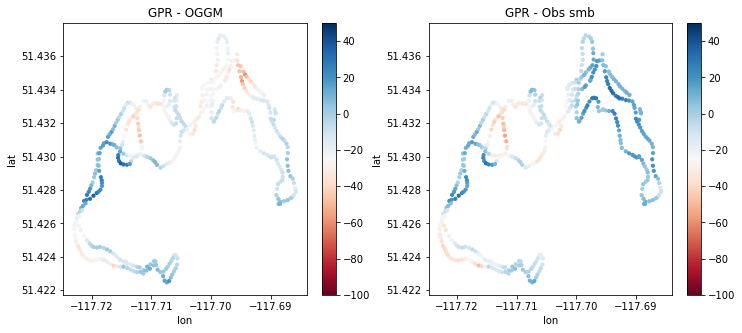

In [170]:
#GPR depth less oggm default thickness
# geom = gdir.read_shapefile('outlines')
f, (ax,ax1) = plt.subplots(1,2, figsize=(12, 5))
df_agg['GPR-oggm'] = df_agg['depth'] - df_agg['oggm_thick']
df_agg.plot.scatter(x='lon', y='lat', c=df_agg['GPR-oggm'], cmap='RdBu', s=10, ax=ax, vmax=50, vmin=-100); #cmap='Blues',
ax.title.set_text('GPR - OGGM')
# geom.plot(ax=ax, facecolor='no
#GPR depth less OGGM SMB thickness


geom = gdir.read_shapefile('outlines')
df_agg['GPR-obs_smb'] = df_agg['depth'] - df_agg['obs_mb_grad_thick']
df_agg.plot.scatter(x='lon', y='lat', c=df_agg['GPR-obs_smb'], cmap='RdBu', s=10, vmax=50, vmin=-100, ax=ax1); #cmap='Blues',
ax1.title.set_text('GPR - Obs smb')
# geom.plot(ax=ax) #facecolor='no)

In [171]:
# df_agg.to_csv(products_dir + glacier[num] + '_MBgrad.csv', index=False)
df_agg.to_csv(products_dir + glacier[num] + '_OPT.csv', index=False)
# ds_new.to_netcdf(products_dir + glacier[num] + '_MBgrad_gridded.nc')

In [172]:
ds_new

<xarray.Dataset>
Dimensions:                (x: 116, y: 73)
Coordinates:
  * x                      (x) float32 -2315.128 -2276.128 ... 2130.872 2169.872
  * y                      (y) float32 5699030.0 5698991.0 ... 5696222.0
Data variables:
    topo                   (y, x) float32 2277.0 2265.0 2252.0 ... 2246.0 2242.0
    topo_smoothed          (y, x) float32 2268.8572 2263.7112 ... 2252.4224
    topo_valid_mask        (y, x) int8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    glacier_mask           (y, x) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    glacier_ext            (y, x) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    glacier_ext_erosion    (y, x) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    ice_divides            (y, x) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    slope                  (y, x) float32 0.13321918 0.17616582 ... 0.09104551
    aspect                 (y, x) float32 1.3950498 1.4412681 ... 2.244595
    slope_factor           (y, x) float32 3.3516603 2.8343081 ... 3.8724234
    dis_from_border        (y, x) float32 1170.0 1147.0244 ... 1070.9033
    distributed_thickness  (y, x) float32 nan nan nan nan ... nan nan nan nan
    obs-default            (y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    proj_srs:       +proj=tmerc +lat_0=0 +lon_0=-117.71 +k=0.9996 +x_0=0 +y_0...
    max_h_dem:      2949.0
    min_h_dem:      1921.0
    max_h_glacier:  2946.0
    min_h_glacier:  1966.0